In [5]:
import fastjet as fj
import pythia8
from recursivetools import pyrecursivetools as rt
from lundplane import pylundplane as lund
from pythiafjtools import pypythiafjtools as pyfj
import math
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'
from tqdm import tnrange, tqdm_notebook
import joblib
import os

In [6]:
def deltas(jets, jets0):
    for i in range(len(jets)):
        yield jets0[i].perp() - jets[i].perp()

def create_and_init_pythia(config_strings=[]):
    pythia = pythia8.Pythia()
    for s in config_strings:
        pythia.readString(s)
    for extra_s in ["Next:numberShowEvent = 0", "Next:numberShowInfo = 0", "Next:numberShowProcess = 0"]:
        pythia.readString(extra_s)
    if pythia.init():
        return pythia
    return None

sconfig_pythia = [ "Beams:eCM = 8000.", "HardQCD:all = on", "PhaseSpace:pTHatMin = 100."]
pythia = create_and_init_pythia(sconfig_pythia)

# set up our jet definition and a jet selector
jet_R0 = 0.4
jet_def = fj.JetDefinition(fj.antikt_algorithm, jet_R0)
jet_selector = fj.SelectorPtMin(100.0) & fj.SelectorPtMax(200.0) & fj.SelectorAbsEtaMax(1)
sd = rt.SoftDrop(0, 0.1, 1.0)

In [7]:
all_jets = []
for iEvent in tqdm_notebook(range(10000), 'event'):
    if not pythia.next(): continue
    parts = pyfj.vectorize(pythia, True, -1, 1, False)
    jets = jet_selector(jet_def(parts))
    all_jets.extend(jets)

In [8]:
jet_def_lund = fj.JetDefinition(fj.cambridge_algorithm, 1.0)
lund_gen = lund.LundGenerator(jet_def_lund)

In [9]:
%%time
lunds = [lund_gen.result(j) for j in all_jets]

CPU times: user 132 ms, sys: 20.1 ms, total: 152 ms
Wall time: 152 ms


In [10]:
%%time
log_kt = []
log_1oDelta = []
for l in lunds:
    for s in l:
        log_kt.append(math.log(s.kt()))
        log_1oDelta.append(math.log(1./s.Delta()))

CPU times: user 111 ms, sys: 2.62 ms, total: 113 ms
Wall time: 113 ms


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 2., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.66392995, 0.7503647 , 0.83679944, 0.92323419, 1.00966893,
        1.09610368, 1.18253843, 1.26897317, 1.35540792, 1.44184267,
        1.52827741, 1.61471216, 1.7011469 , 1.78758165, 1.8740164 ,
        1.96045114, 2.04688589, 2.13332063, 2.21975538, 2.30619013,
        2.39262487, 2.47905962, 2.56549436, 2.65192911, 2.73836386,
        2.8247986 , 2.91123335, 2.9976681 , 3.08410284, 3.17053759,
        3.25697233, 3.34340708, 3.42984183, 3.51627657, 3.60271132,
        3.68914606, 3.77558081, 3.86201556, 3.9484503 , 4.03488505,
        4.1213198 , 4.20775454, 4.29418929, 4.38062403, 4.46705878,
        4.55349353, 4.63992827, 4.72636302, 4.81279776, 4.89923251,
        4.98566726, 5.072102  , 5.15853675, 5.24497149, 5.33140624,
   

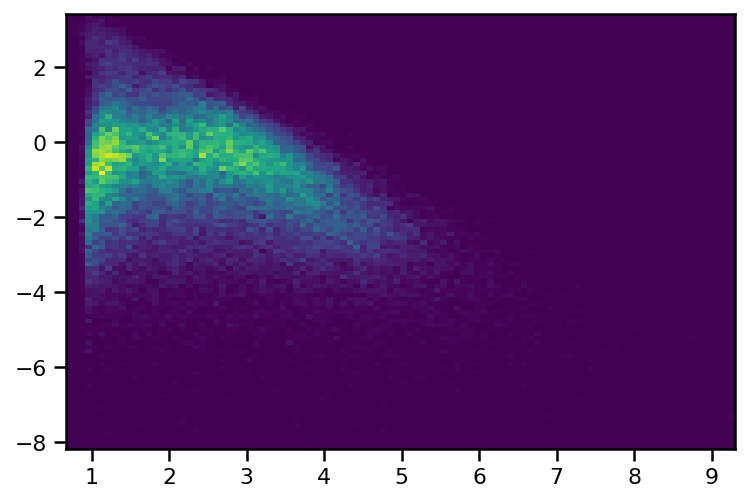

In [11]:
plt.hist2d(log_1oDelta, log_kt, bins=100)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 2., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.66392995, 0.7503647 , 0.83679944, 0.92323419, 1.00966893,
        1.09610368, 1.18253843, 1.26897317, 1.35540792, 1.44184267,
        1.52827741, 1.61471216, 1.7011469 , 1.78758165, 1.8740164 ,
        1.96045114, 2.04688589, 2.13332063, 2.21975538, 2.30619013,
        2.39262487, 2.47905962, 2.56549436, 2.65192911, 2.73836386,
        2.8247986 , 2.91123335, 2.9976681 , 3.08410284, 3.17053759,
        3.25697233, 3.34340708, 3.42984183, 3.51627657, 3.60271132,
        3.68914606, 3.77558081, 3.86201556, 3.9484503 , 4.03488505,
        4.1213198 , 4.20775454, 4.29418929, 4.38062403, 4.46705878,
        4.55349353, 4.63992827, 4.72636302, 4.81279776, 4.89923251,
        4.98566726, 5.072102  , 5.15853675, 5.24497149, 5.33140624,
   

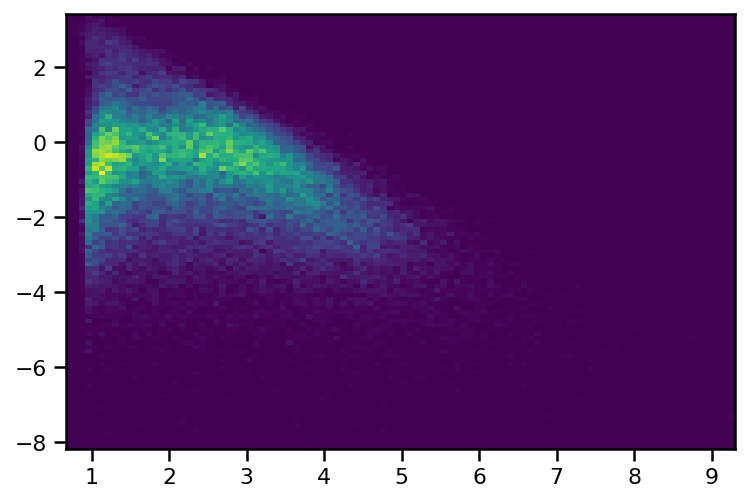

In [12]:
if not os.path.exists('test_lund_2d.joblib'):
    joblib.dump([log_1oDelta, log_kt], 'test_lund_2d.joblib') 
xy = joblib.load('test_lund_2d.joblib')
plt.hist2d(xy[0], xy[1], bins=100)